# Boost CV LB +0.2 with RAPIDS SVR Head
In this notebook, we demonstrate how to add a RAPIDS SVR second head to an already trained CNN or Image Transformer with first head. This boosts CV LB by +0.2! This trick was used in CommonLit Comp [here][3] to boost our team into Gold Medal!

We begin with [Abhishek's][2] public notebook [here][1] which already contains a fully trained Image Transformer model (with NN head). Now in this notebook, we extract the image embeddings (from the trained fold models) and train additional RAPIDS SVR heads for each fold. The original NN head achieves overall CV RSME 18.0 and the new RAPIDS SVR head achieves overall CV RSME 18.0. Both heads are very diverse because the NN head uses Classification (BCE) loss and the SVR head uses Regression loss. During inference, we predict with both heads. When we average both heads' predictions, we achieve overall CV RSME 17.8!

The technique illustrated here can be applied to any trained image (or NLP) model for CV LB boost! In the first version of this notebook, we train the SVR heads and save the fold models. Then, in later notebook versions and during Kaggle submission, we load the saved SVR models (from this notebook's version 1 which was made into a Kaggle dataset).

[1]: https://www.kaggle.com/abhishek/tez-pawpular-swin-ference
[2]: https://www.kaggle.com/abhishek
[3]: https://www.kaggle.com/c/commonlitreadabilityprize/discussion/260800

# How to Add RAPIDS SVR Head
There are 3 steps to building a double headed model. The first step is to train your Image NN backbone and head. This was done by Abhishek in his notebook [here][1] and achieves CV RSME 18.0. The next step is to train our RAPIDS SVR head with extracted embeddings from frozen Image NN backbone. This is done in version 1 of notebook you are reading [here][2] and achieves CV RSME 18.0. Lastly, we infer with both heads and average the predictions. This is done in the notebook you are reading and achieves CV RSME 17.8!

![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Oct-2021/st1.png)
![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Oct-2021/st2.png)
![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Oct-2021/st3.png)

[1]: https://www.kaggle.com/abhishek/tez-pawpular-swin-ference
[2]: https://www.kaggle.com/cdeotte/rapids-svr-boost-17-8?scriptVersionId=76282086

# Load Libraries

In [1]:
# based on the post here: https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/275094

import sys
sys.path.append("../input/tez-lib/")
sys.path.append("../input/timmmaster/")

import tez
import albumentations
import pandas as pd
import cv2
import numpy as np
import timm
import torch.nn as nn
from sklearn import metrics
import torch
from tez.callbacks import EarlyStopping
from tqdm import tqdm
import math

class args:
    batch_size = 16
    image_size = 384
    
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Define Swim Model and Swim Dataset

In [2]:
class PawpularDataset:
    def __init__(self, image_paths, dense_features, targets, augmentations):
        self.image_paths = image_paths
        self.dense_features = dense_features
        self.targets = targets
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = cv2.imread(self.image_paths[item])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
            
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        features = self.dense_features[item, :]
        targets = self.targets[item]
        
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "features": torch.tensor(features, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.float),
        }
    
class PawpularModel(tez.Model):
    def __init__(self, model_name):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False, in_chans=3)
        self.model.head = nn.Linear(self.model.head.in_features, 128)
        self.dropout = nn.Dropout(0.1)
        self.dense1 = nn.Linear(140, 64)
        self.dense2 = nn.Linear(64, 1)

    def forward(self, image, features, targets=None):
        x1 = self.model(image)
        x = self.dropout(x1)
        x = torch.cat([x, features], dim=1)
        x = self.dense1(x)
        x = self.dense2(x)
        
        x = torch.cat([x, x1, features], dim=1)
        return x, 0, {}
    
test_aug = albumentations.Compose(
    [
        albumentations.Resize(args.image_size, args.image_size, p=1),
        albumentations.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0,
        ),
    ],
    p=1.0,
)

# Import RAPIDS

In [3]:
import cuml, pickle
from cuml.svm import SVR
print('RAPIDS version',cuml.__version__,'\n')

LOAD_SVR_FROM_PATH = '../input/svr-models-10-folds/'

df = pd.read_csv('../input/same-old-creating-folds/train_10folds.csv')
print('Train shape:', df.shape )
df.head()

RAPIDS version 21.08.01 

Train shape: (9912, 15)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,kfold
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,1
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,5
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,1
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,6
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,8


# Infer Test and OOF
In version 1 of this notebook, we extract train embeddings and train RAPIDS SVR heads. (Click version 1 to see this). In later versions and during Kaggle submit, we load these saved RAPIDS SVR fold models and just infer data (without training anything).

In [4]:
super_final_predictions = []
super_final_predictions2 = []
super_final_oof_predictions = []
super_final_oof_predictions2 = []
super_final_oof_true = []

for fold_ in range(10):
    print('#'*25)
    print('### FOLD',fold_+1)
    print('#'*25)
    
    model = PawpularModel(model_name="swin_large_patch4_window12_384")
    model.load(f"../input/paw-models/model_f{fold_}.bin", device="cuda", weights_only=True)

    df_test = pd.read_csv("../input/petfinder-pawpularity-score/test.csv")
    test_img_paths = [f"../input/petfinder-pawpularity-score/test/{x}.jpg" for x in df_test["Id"].values]
        
    df_valid = df[df.kfold == fold_].reset_index(drop=True)#.iloc[:160]
    valid_img_paths = [f"../input/petfinder-pawpularity-score/train/{x}.jpg" for x in df_valid["Id"].values]

    dense_features = [
        'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
        'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'
    ]
    
    name = f"SVR_fold_{fold_}.pkl" 
    if LOAD_SVR_FROM_PATH is None:
        ##################
        # EXTRACT TRAIN EMBEDDINGS
        
        df_train = df[df.kfold != fold_].reset_index(drop=True)#.iloc[:320]
        train_img_paths = [f"../input/petfinder-pawpularity-score/train/{x}.jpg" for x in df_train["Id"].values]
        
        train_dataset = PawpularDataset(
            image_paths=train_img_paths,
            dense_features=df_train[dense_features].values,
            targets=df_train['Pawpularity'].values/100.0,
            augmentations=test_aug,
        )
        print('Extracting train embedding...')
        train_predictions = model.predict(train_dataset, batch_size=2*args.batch_size, n_jobs=-1)
    
        embed = np.array([]).reshape((0,128+12))
        for preds in train_predictions:
            embed = np.concatenate([embed,preds[:,1:]],axis=0)
        
        ##################
        # FIT RAPIDS SVR
        print('Fitting SVR...')
        clf = SVR(C=20.0)
        clf.fit(embed.astype('float32'), df_train.Pawpularity.values.astype('int32'))
    
        ##################
        # SAVE RAPIDS SVR 
        pickle.dump(clf, open(name, "wb"))
        
    else:
        ##################
        # LOAD RAPIDS SVR 
        print('Loading SVR...',LOAD_SVR_FROM_PATH+name)
        clf = pickle.load(open(LOAD_SVR_FROM_PATH+name, "rb"))

    ##################
    # TEST PREDICTIONS
    test_dataset = PawpularDataset(
        image_paths=test_img_paths,
        dense_features=df_test[dense_features].values,
        targets=np.ones(len(test_img_paths)),
        augmentations=test_aug,
    )
    print('Predicting test...')
    test_predictions = model.predict(test_dataset, batch_size=2*args.batch_size, n_jobs=-1)

    final_test_predictions = []
    embed = np.array([]).reshape((0,128+12))
    for preds in test_predictions: #tqdm
        final_test_predictions.extend(preds[:,:1].ravel().tolist())
        embed = np.concatenate([embed,preds[:,1:]],axis=0)

    final_test_predictions = [sigmoid(x) * 100 for x in final_test_predictions]
    final_test_predictions2 = clf.predict(embed)
    super_final_predictions.append(final_test_predictions)
    super_final_predictions2.append(final_test_predictions2)
    ##################
    
    ##################
    # OOF PREDICTIONS
    valid_dataset = PawpularDataset(
        image_paths=valid_img_paths,
        dense_features=df_valid[dense_features].values,
        targets=df_valid['Pawpularity'].values/100.0,
        augmentations=test_aug,
    )
    print('Predicting oof...')
    valid_predictions = model.predict(valid_dataset, batch_size=2*args.batch_size, n_jobs=-1)

    final_oof_predictions = []
    embed = np.array([]).reshape((0,128+12))
    for preds in valid_predictions:
        final_oof_predictions.extend(preds[:,:1].ravel().tolist())
        embed = np.concatenate([embed,preds[:,1:]],axis=0)

    final_oof_predictions = [sigmoid(x) * 100 for x in final_oof_predictions]
    final_oof_predictions2 = clf.predict(embed)    
    super_final_oof_predictions.append(final_oof_predictions)
    super_final_oof_predictions2.append(final_oof_predictions2)
    
    final_oof_true = df_valid['Pawpularity'].values
    super_final_oof_true.append(final_oof_true)
    ##################
    
    ##################
    # COMPUTE RSME
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_oof_predictions[-1]))**2.0 ) )
    print('NN RSME =',rsme,'\n')
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_oof_predictions2[-1]))**2.0 ) )
    print('SVR RSME =',rsme,'\n')
    
    w = 0.5
    oof2 = (1-w)*np.array(super_final_oof_predictions[-1]) + w*np.array(super_final_oof_predictions2[-1])
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - oof2)**2.0 ) )
    print('Ensemble RSME =',rsme,'\n')

#########################
### FOLD 1
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_0.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.36it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:44<00:00,  1.42s/it, stage=test]


NN RSME = 17.885706951550716 

SVR RSME = 18.270196793851838 

Ensemble RSME = 17.85101016657597 

#########################
### FOLD 2
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_1.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.71it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:44<00:00,  1.43s/it, stage=test]


NN RSME = 18.180458903665826 

SVR RSME = 18.087203473572476 

Ensemble RSME = 17.96400149394548 

#########################
### FOLD 3
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_2.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.67it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:43<00:00,  1.41s/it, stage=test]


NN RSME = 18.174499147617055 

SVR RSME = 18.63462838971806 

Ensemble RSME = 18.262901999688694 

#########################
### FOLD 4
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_3.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.63it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:43<00:00,  1.41s/it, stage=test]


NN RSME = 18.21322085813045 

SVR RSME = 18.61290296074279 

Ensemble RSME = 18.21185362750887 

#########################
### FOLD 5
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_4.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.67it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:44<00:00,  1.42s/it, stage=test]


NN RSME = 18.379703734384243 

SVR RSME = 18.657330732508147 

Ensemble RSME = 18.255886900976734 

#########################
### FOLD 6
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_5.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.62it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:43<00:00,  1.42s/it, stage=test]


NN RSME = 17.604086467656092 

SVR RSME = 17.840501215098953 

Ensemble RSME = 17.616803115805926 

#########################
### FOLD 7
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_6.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.66it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:43<00:00,  1.41s/it, stage=test]


NN RSME = 18.194533099140646 

SVR RSME = 17.675722437167224 

Ensemble RSME = 17.52104106683986 

#########################
### FOLD 8
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_7.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.53it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:44<00:00,  1.42s/it, stage=test]


NN RSME = 17.36336004792075 

SVR RSME = 17.38088159778331 

Ensemble RSME = 17.14418426064325 

#########################
### FOLD 9
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_8.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.41it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:43<00:00,  1.41s/it, stage=test]


NN RSME = 18.124772264918583 

SVR RSME = 17.776294589506946 

Ensemble RSME = 17.63281675918235 

#########################
### FOLD 10
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_9.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.67it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:43<00:00,  1.41s/it, stage=test]

NN RSME = 18.164906634868263 

SVR RSME = 17.45609180569719 

Ensemble RSME = 17.543734605981193 



# Compute CV Score
Below we compute the overall CV RSME scores of just the NN head, just the SVR head, and an ensemble of 50% NN and 50% SVR heads. Then we plot all ensemble weights to find the optimal weights for NN head and SVR heads.

In [5]:
true = np.hstack(super_final_oof_true)

oof = np.hstack(super_final_oof_predictions)
rsme = np.sqrt( np.mean( (oof - true)**2.0 ))
print('Overall CV NN head RSME =',rsme)

oof2 = np.hstack(super_final_oof_predictions2)
rsme = np.sqrt( np.mean( (oof2 - true)**2.0 ))
print('Overall CV SVR head RSME =',rsme)

oof3 = (1-w)*oof + w*oof2
rsme = np.sqrt( np.mean( (oof3 - true)**2.0 ))
print('Overall CV Ensemble heads RSME with 50% NN and 50% SVR =',rsme)

Overall CV NN head RSME = 18.031021894289673
Overall CV SVR head RSME = 18.04512069078766
Overall CV Ensemble heads RSME with 50% NN and 50% SVR = 17.803972947752452


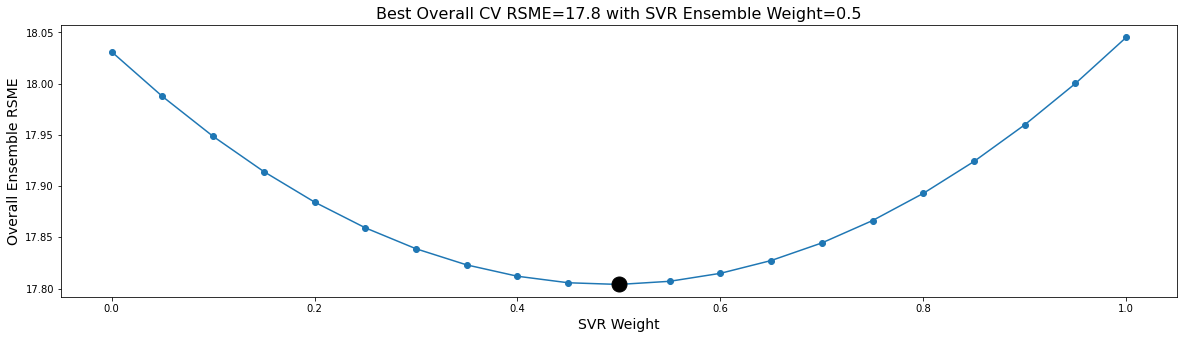

In [6]:
import matplotlib.pyplot as plt

score = []
for ww in np.arange(0,1.05,0.05):
    oof3 = (1-ww)*oof + ww*oof2
    rsme = np.sqrt( np.mean( (oof3 - true)**2.0 ))
    #print(f'{ww:0.2} CV Ensemble RSME =',rsme)
    score.append(rsme)
best_w = np.argmin(score)*0.05

plt.figure(figsize=(20,5))
plt.plot(np.arange(21)/20.0,score,'-o')
plt.plot([best_w],np.min(score),'o',color='black',markersize=15)
plt.title(f'Best Overall CV RSME={np.min(score):.4} with SVR Ensemble Weight={best_w:.2}',size=16)
plt.ylabel('Overall Ensemble RSME',size=14)
plt.xlabel('SVR Weight',size=14)
plt.show()

# Trust CV or LB?
Above we see that using 50% NN head and 50% SVR head achieves the best overall CV score. However our RAPIDS SVR head isn't helping public LB much. We also notice that our RAPIDS SVR head helped folds `1, 2, 4, 5, 7, 8, 9, 10` but did not help folds `3, 6`. So is public test data just a "bad fold"? Will our RAPIDS SVR head help private LB? Below we force the weight of SVR head to be 10% in order to achieve a slight public LB boost. But maybe for final submission, we should use 50%??

In [7]:
# FORCE SVR WEIGHT TO LOWER VALUE TO HELP PUBLIC LB
best_w = 0.2

# Make Submission CSV
We make a submission csv using an ensemble of both heads. We use the optimal ensemble weights that we discovered above.

In [8]:
super_final_predictions = np.mean(np.column_stack(super_final_predictions), axis=1)
super_final_predictions2 = np.mean(np.column_stack(super_final_predictions2), axis=1)
df_test["Pawpularity"] = (1-best_w)*super_final_predictions + best_w*super_final_predictions2
df_test = df_test[["Id", "Pawpularity"]]
df_test.to_csv("submission.csv", index=False)
df_test.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,38.029146
1,43a2262d7738e3d420d453815151079e,37.308950
2,4e429cead1848a298432a0acad014c9d,36.416784
3,80bc3ccafcc51b66303c2c263aa38486,36.117093
4,8f49844c382931444e68dffbe20228f4,36.325476
